##  Multi-Contact dynamics for biped walking (Talos legs)
In this example, we describe the multi-contact dynamics through holonomic constraints for the support legs. From the Gauss principle, we have derived the model as:
$$
\left[\begin{matrix}
 \mathbf{M} & \mathbf{J}^{\top}_c \\
 {\mathbf{J}_{c}} & \mathbf{0} \\
\end{matrix}\right]
\left[\begin{matrix}
 \dot{\mathbf{v}} \\ -\boldsymbol{\lambda}
\end{matrix}\right]
 = 
\left[\begin{matrix}
  \boldsymbol{\tau} - \mathbf{h} \\
  -\dot{\mathbf{J}}_c \mathbf{v} \\
\end{matrix}\right]$$.


Base on a predefined walking gait, we build per each phase a specific multi-contact dynamics. Indeed we need to describe multi-phase optimal control problem. One can formulate the multi-contact optimal control problem (MCOP) as follows:


$$\mathbf{X}^*,\mathbf{U}^*=
\begin{Bmatrix} \mathbf{x}^*_0,\cdots,\mathbf{x}^*_N \\
				  \mathbf{u}^*_0,\cdots,\mathbf{u}^*_N
\end{Bmatrix} =
\arg\min_{\mathbf{X},\mathbf{U}} \sum_{p=0}^P \sum_{k=1}^{N(p)} \int_{t_k}^{t_k+\Delta t} l_p(\mathbf{x},\mathbf{u})dt$$
subject to
$$ \mathbf{\dot{x}} = \mathbf{f}_p(\mathbf{x},\mathbf{u}), \text{for } t \in [\tau_p,\tau_{p+1}]$$

$$ \mathbf{g}(\mathbf{v}^{p+1},\mathbf{v}^p) = \mathbf{0}$$

$$ \mathbf{x}\in\mathcal{X}_p, \mathbf{u}\in\mathcal{U}_p, \boldsymbol{\lambda}\in\mathcal{K}_p.$$

where $\mathbf{g}(\cdot,\cdot,\cdot)$ describes the contact dynamics, and they represents terminal constraints in each walking phase. In this example we use the following impact model:

$$\mathbf{M}(\mathbf{v}_{next}-\mathbf{v}) = \mathbf{J}_{impulse}^T$$

$$\mathbf{J}_{impulse} \mathbf{v}_{next} = \mathbf{0}$$

$$\mathbf{J}_{c} \mathbf{v}_{next} = \mathbf{J}_{c} \mathbf{v}$$



First, let's define walking shooting problem:

In [15]:
from crocoddyl import StatePinocchio
from crocoddyl import DifferentialActionModelFloatingInContact
from crocoddyl import IntegratedActionModelEuler
from crocoddyl import CostModelSum
from crocoddyl import CostModelFramePlacement, CostModelFrameVelocity
from crocoddyl import CostModelState, CostModelControl
from crocoddyl import ActuationModelFreeFloating
from crocoddyl import ContactModel6D, ContactModelMultiple
from crocoddyl import ShootingProblem
import pinocchio
from pinocchio.utils import *


class TaskSE3:
    def __init__(self, oXf, frameId):
        self.oXf = oXf
        self.frameId = frameId


class SimpleBipedWalkingProblem:
    """ Defines a simple 3d locomotion problem
    """
    def __init__(self, robot, rightFoot, leftFoot):
        self.robot = robot
        self.state = StatePinocchio(self.robot.model)
        self.rightFoot = rightFoot
        self.leftFoot = leftFoot

    def createProblem(self, x, stepLength, stepDuration):
        # Computing the time step per each contact phase given the step duration.
        # Here we assume a constant number of knots per phase
        numKnots = 20
        timeStep = float(stepDuration)/numKnots

        # Getting the frame id for the right and left foot
        rightFootId = self.robot.model.getFrameId(self.rightFoot)
        leftFootId = self.robot.model.getFrameId(self.leftFoot)

        # Compute the current foot positions
        q0 = a2m(x[:self.robot.nq])
        rightFootPos0 = self.robot.framePlacement(q0, rightFootId).translation
        leftFootPos0 = self.robot.framePlacement(q0, leftFootId).translation

        # Defining the action models along the time instances
        n_cycles = 2
        loco3dModel = []
        import copy
        for i in range(n_cycles):
            # swing LF phase
            leftSwingModel = \
                [ self.createContactPhaseModel(
                    timeStep,
                    rightFootId,
                    TaskSE3(
                        pinocchio.SE3(np.eye(3),
                                      np.asmatrix(a2m([ [(stepLength*k)/numKnots, 0., 0.] ]) +
                                      leftFootPos0)),
                        leftFootId)
                    ) for k in range(numKnots) ]
            
            # Double support phase
            doubleSupportModel = \
                self.createContactSwitchModel(
                    rightFootId,
                    TaskSE3(
                        pinocchio.SE3(np.eye(3),
                                      np.asmatrix(a2m([ stepLength, 0., 0. ]) +
                                      leftFootPos0)),
                        leftFootId)
                    )
            
            # swing RF phase
            rightSwingModel = \
                [ self.createContactPhaseModel(
                    timeStep,
                    leftFootId,
                    TaskSE3(
                        pinocchio.SE3(np.eye(3),
                                      np.asmatrix(a2m([ 2*(stepLength*k)/numKnots, 0., 0. ]) +
                                      rightFootPos0)),
                        rightFootId)
                    ) for k in range(numKnots) ]
            
            # Final support phase
            finalSupport = \
                self.createContactSwitchModel(
                    leftFootId,
                    TaskSE3(
                        pinocchio.SE3(np.eye(3),
                                      np.asmatrix(a2m([ 2*stepLength, 0., 0. ]) +
                                      rightFootPos0)),
                        rightFootId),
                    )
            rightFootPos0 += np.asmatrix(a2m([ stepLength, 0., 0. ]))
            leftFootPos0 += np.asmatrix(a2m([ stepLength, 0., 0. ]))
            loco3dModel += leftSwingModel + [ doubleSupportModel ] + rightSwingModel + [ finalSupport ]

        problem = ShootingProblem(x, loco3dModel, finalSupport)
        return problem

    def createContactPhaseModel(self, timeStep, contactFootId, footSwingTask):
        # Creating the action model for floating-base systems. A walker system 
        # is by default a floating-base system
        actModel = ActuationModelFreeFloating(self.robot.model)

        # Creating a 6D multi-contact model, and then including the supporting
        # foot
        contactModel = ContactModelMultiple(self.robot.model)
        contactFootModel = \
            ContactModel6D(self.robot.model, contactFootId, ref=None)
        contactModel.addContact('contact', contactFootModel)

        # Creating the cost model for a contact phase
        costModel = CostModelSum(self.robot.model, actModel.nu)
        footTrack = CostModelFramePlacement(self.robot.model,
                                            footSwingTask.frameId,
                                            footSwingTask.oXf,
                                            actModel.nu)
        stateReg = CostModelState(self.robot.model,
                                  self.state)
        stateReg.weights = \
            np.array([0]*6 + [0.01]*(self.robot.model.nv-6) + [10]*self.robot.model.nv)
        ctrlReg = CostModelControl(self.robot.model, actModel.nu)
        costModel.addCost("footTrack", footTrack, 100.)
        costModel.addCost("stateReg", stateReg, 0.1)
        costModel.addCost("ctrlReg", ctrlReg, 0.001)

        # Creating the action model for the KKT dynamics with simpletic Euler
        # integration scheme
        dmodel = \
            DifferentialActionModelFloatingInContact(self.robot.model,
                                                     actModel,
                                                     contactModel,
                                                     costModel)
        model = IntegratedActionModelEuler(dmodel)
        model.timeStep = timeStep
        return model

    def createContactSwitchModel(self, contactFootId, swingFootTask):
        model = self.createContactPhaseModel(0., contactFootId, swingFootTask)

        impactFootVelCost = \
            CostModelFrameVelocity(self.robot.model, swingFootTask.frameId)
        model.differential.costs.addCost('impactVel', impactFootVelCost, 10000.)
        model.differential.costs['impactVel' ].weight = 100000
        model.differential.costs['footTrack' ].weight = 100000
        model.differential.costs['stateReg'].weight = 1
        model.differential.costs['ctrlReg'].weight = 0.01
        return model

This class builds action models for each locomotion phase:
  - createContactPhaseModel: defines an action model for the swing phase
  - createContactSwitchModel: defines an action model for switch knots between phases
  
Then we build a walking by combining a set of contact phases and their contact switches.

Now let's create a walking OC problem for the Talos legs.

In [19]:
from crocoddyl import SolverDDP
from crocoddyl import CallbackDDPLogger, CallbackDDPVerbose, CallbackSolverDisplay
from crocoddyl import loadTalosLegs
from crocoddyl import m2a, a2m


talos_legs = loadTalosLegs()
talos_legs.model.armature[6:] = 1. #No armature

# Setting up the 3d walking problem
rightFoot = 'right_sole_link'
leftFoot = 'left_sole_link'
walk = SimpleBipedWalkingProblem(talos_legs, rightFoot, leftFoot)


# Create the initial state
q = talos_legs.q0.copy()
v = zero(talos_legs.model.nv)
x = m2a(np.concatenate([q,v]))

# Solving the 3d walking problem using DDP
stepLength = 0.2
stepDuration = 0.75
ddp = SolverDDP(walk.createProblem(x, stepLength, stepDuration))
cameraTF = [3., 3.68, 0.84, 0.2, 0.62, 0.72, 0.22]
ddp.callback = [CallbackDDPLogger(), CallbackDDPVerbose(), CallbackSolverDisplay(talos_legs,4,cameraTF)]
ddp.th_stop = 1e-9
ddp.solve(maxiter=1000,regInit=.1)

iter 	 cost 	      theta 	    gamma 	  muV 	      muLM 	 alpha
   0  1.75872e+06  3.98534e+06  1.01608e+06  1.00000e-02  1.00000e-02  1.0000
   1  6.60121e+05  9.28539e+08  3.50823e+06  1.00000e-03  1.00000e-03  1.0000
   2  1.93867e+05  3.47290e+08  1.31840e+06  1.00000e-04  1.00000e-04  1.0000
   3  4.86463e+03  6.02376e+07  3.86684e+05  1.00000e-05  1.00000e-05  1.0000
   4  2.83783e+03  1.06563e+06  8.82042e+03  1.00000e-06  1.00000e-06  1.0000
   5  4.71728e+02  1.30635e+06  4.77260e+03  1.00000e-07  1.00000e-07  1.0000
   6  4.51319e+02  9.25467e+03  4.08153e+01  1.00000e-08  1.00000e-08  1.0000
   7  4.51314e+02  1.41238e-01  9.60388e-03  1.00000e-09  1.00000e-09  1.0000
   8  4.51314e+02  7.81621e-04  4.87315e-04  1.00000e-09  1.00000e-09  1.0000
   9  4.51314e+02  2.02318e-06  3.01584e-05  1.00000e-09  1.00000e-09  1.0000
iter 	 cost 	      theta 	    gamma 	  muV 	      muLM 	 alpha
  10  4.51314e+02  1.90932e-07  1.91847e-06  1.00000e-09  1.00000e-09  1.0000
  11  4.51314e+0

([array([ 0.      ,  0.      ,  1.019   ,  0.      ,  0.      ,  0.      ,
          1.      ,  0.      ,  0.      , -0.411354,  0.859395, -0.448041,
         -0.001708,  0.      ,  0.      , -0.411354,  0.859395, -0.448041,
         -0.001708,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ]),
  array([ 2.80934643e-03, -4.26400956e-04,  1.02037836e+00, -1.81135550e-04,
          1.26566181e-03, -3.54630117e-04,  9.99999120e-01,  9.57728181e-04,
         -1.96697783e-03, -4.15263341e-01,  8.51376573e-01, -4.37912808e-01,
         -5.72382160e-04,  7.09260442e-04,  1.15710202e-03, -4.06200908e-01,
          8.49610579e-01, -4.45940995e-01, -2.50283081e-03,  7.48733749e-02,
         -1.13507932e-02,  3.68489629e-02, -9.66056549e-03,  6.75019832e-02,
         -1.89136118e-02,  2.55394182e-02, -5.24527422e-02, -1.042

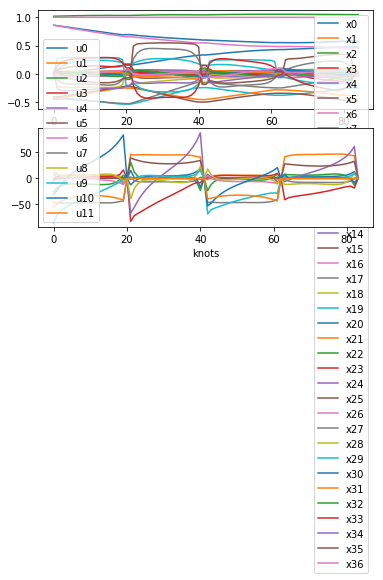

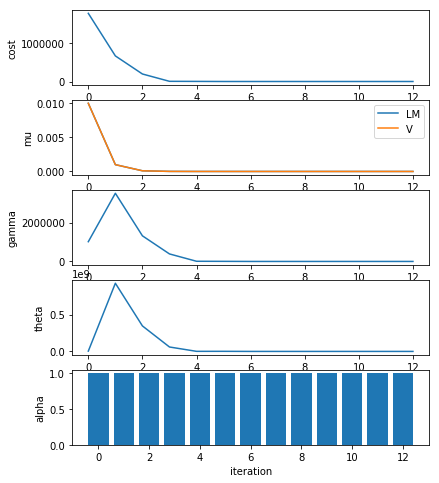

In [18]:
from crocoddyl import plotOCSolution, plotDDPConvergence

# Plotting the solution and the DDP convergence
log = ddp.callback[0]
plotOCSolution(log.xs, log.us)
plotDDPConvergence(log.costs,log.control_regs,
                   log.state_regs,log.gm_stops,
                   log.th_stops,log.steps)
